In [1]:
import sqlite3
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
%matplotlib inline

In [2]:
def run_query(q):
    with sqlite3.connect('chinook.db') as conn:
        return pd.read_sql(q, conn)
    
def run_command(c):
    with sqlite3.connect('chinook.db') as conn:
        conn.isolation_level = None
        conn.execute(c)

In [3]:
def show_tables():
    q = "SELECT * FROM sqlite_master WHERE type='table'"
    return run_query(q)

In [4]:
show_tables()

,type,name,tbl_name,rootpage,sql
0,table,album,album,2,CREATE TABLE [album]\n(\n [album_id] INTEGE...
1,table,artist,artist,3,CREATE TABLE [artist]\n(\n [artist_id] INTE...
2,table,customer,customer,4,CREATE TABLE [customer]\n(\n [customer_id] ...
3,table,employee,employee,5,CREATE TABLE [employee]\n(\n [employee_id] ...
4,table,genre,genre,6,CREATE TABLE [genre]\n(\n [genre_id] INTEGE...
5,table,invoice,invoice,7,CREATE TABLE [invoice]\n(\n [invoice_id] IN...
6,table,invoice_line,invoice_line,8,CREATE TABLE [invoice_line]\n(\n [invoice_l...
7,table,media_type,media_type,9,CREATE TABLE [media_type]\n(\n [media_type_...
8,table,playlist,playlist,10,CREATE TABLE [playlist]\n(\n [playlist_id] ...
9,table,playlist_track,playlist_track,11,CREATE TABLE [playlist_track]\n(\n [playlis...


In [5]:
q = "SELECT COUNT(*) FROM invoice_line"
run_query(q)

,COUNT(*)
0,4757


In [6]:
q = """
SELECT g.name genre, COUNT(*) totals, CAST(SUM(quantity) AS float) / CAST((SELECT COUNT(*) FROM invoice_line) AS float) * 100 percentage FROM invoice_line il
INNER JOIN track tr ON il.track_id = tr.track_id
INNER JOIN genre g ON g.genre_id = tr.genre_id
GROUP BY g.name
ORDER BY percentage DESC
"""

genre_amt = run_query(q)
run_query(q)

,genre,totals,percentage
0,Rock,2635,55.392054
1,Metal,619,13.012403
2,Alternative & Punk,492,10.342653
3,Latin,167,3.510616
4,R&B/Soul,159,3.342443
5,Blues,124,2.606685
6,Jazz,121,2.543620
7,Alternative,117,2.459533
8,Easy Listening,74,1.555602
9,Pop,63,1.324364


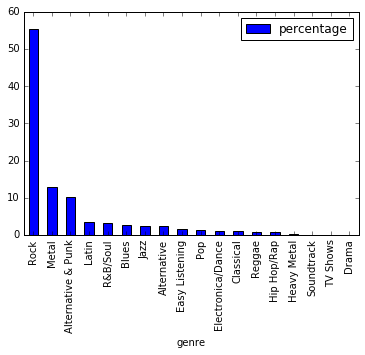

In [7]:
genre_amt.set_index("genre",drop=True,inplace=True)
genre_amt.plot.bar(y='percentage')

It's unfortunate we don't have a rock artist lined up. But it's clear that we should put most of our efforts into "Red Tone", the Punk band. After them "Slim Jim Bites" and "Meteor and the Girls." We just haven't sold enough Hip Hop  to merrit even giving it a look. The other three are in the top half of cateories we've sold. Hip hop is just above our bottom quartile,

In [8]:
q = """
SELECT Sum(total), e.first_name || " " || e.last_name name, 
e.hire_date FROM invoice i
INNER JOIN customer c ON c.customer_id = i.customer_id
INNER JOIN employee e2 ON e2.employee_id = e.reports_to
INNER JOIN employee e ON e.employee_id = c.support_rep_id
GROUP BY name
ORDER BY e.hire_date ASC
"""
sales_numbers = run_query(q)
print(sales_numbers)

   Sum(total)           name            hire_date
0     1731.51   Jane Peacock  2017-04-01 00:00:00
1     1584.00  Margaret Park  2017-05-03 00:00:00
2     1393.92  Steve Johnson  2017-10-17 00:00:00


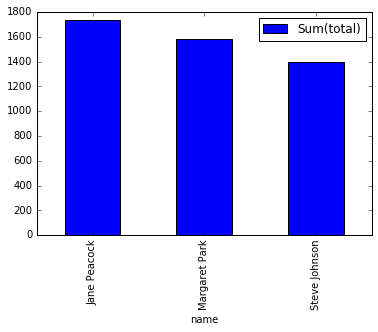

In [9]:
sales_numbers.set_index('name',drop=True, inplace = True)
sales_numbers.plot.bar()

It's clear from the table that the earlier the highering date, the better the sales numbers for each associate. We'd need to normalize this data somehow to really compare the associates.

In [10]:
c = """
CREATE VIEW customer_stats AS
    SELECT 
        customer_id,
        SUM(total) total_spent,
        COUNT(*) purchases
    FROM invoice
    GROUP BY customer_id
"""

In [11]:
q = """ 
SELECT 
    Country, 
    SUM(cc) Customers, 
    SUM(total) Total_Sales, 
    CAST(SUM(total) as float) / CAST(SUM(cc) as float) AVG_sales_customer, 
    CAST(SUM(total) as float) /CAST(SUM(purchases) as float) Average_Order_Value 
    FROM
        (SELECT
            CASE
                WHEN COUNT(c.country) = 1 THEN 'Other'
                ELSE c.country
            END AS country,
            COUNT(country) cc,
            SUM(cs.total_spent) total,
            SUM(cs.purchases) purchases
        FROM customer c
        INNER JOIN customer_stats cs ON cs.customer_id = c.customer_id
        GROUP BY country)
GROUP BY country
ORDER BY Customers ASC
"""
country_tallies = run_query(q)
run_query(q)

,country,Customers,Total_Sales,AVG_sales_customer,Average_Order_Value
0,Czech Republic,2,273.24,136.620000,9.108000
1,India,2,183.15,91.575000,8.721429
2,Portugal,2,185.13,92.565000,6.383793
3,United Kingdom,3,245.52,81.840000,8.768571
4,Germany,4,334.62,83.655000,8.161463
5,Brazil,5,427.68,85.536000,7.011148
6,France,5,389.07,77.814000,7.781400
7,Canada,8,535.59,66.948750,7.047237
8,USA,13,1040.49,80.037692,7.942672
9,Other,15,1094.94,72.996000,7.448571


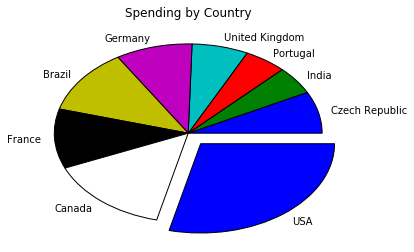

In [12]:
plt.pie(country_tallies['Total_Sales'].iloc[0:9],labels=country_tallies['country'].iloc[0:9],
       explode = (0,0,0,0,0,0,0,0,0.15))
plt.title('Spending by Country')
plt.show()

The above is a pie chart of the spending by country. It would be helpful to figure out how to color it differently, especially given that the Czech Republic and USA show up as teh same color. The USA is 'exploded' because it has the most spending, so it's good to highlight it.

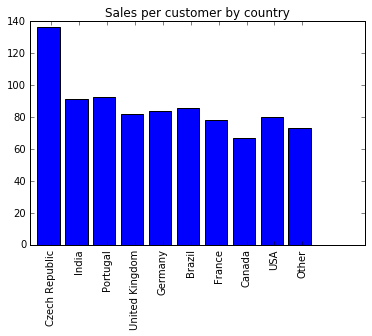

In [13]:
sales_customer = country_tallies['AVG_sales_customer']
plt.bar(np.arange(len(sales_customer)) + .25,sales_customer,
       tick_label = (country_tallies['country']))
plt.xticks(np.arange(len(sales_customer))+.75,rotation = 'vertical')
plt.title('Sales per customer by country')
plt.show()

This graph might reveal which countries to target for future customer growth. Even though the US had more spending in total (as shown above), the Czech Republic had more spending per customer. This <em>might</em> mean that prioritizing customers from the Czech Republic would have a greater per capita impact.  If we could somehow create the same number of customers there, our overall spending would improve more rapidly. Then again, there are far less people there.

In [23]:
q = """
SELECT a.album_id, COUNT(DISTINCT(track_id)) FROM 
    album a
    INNER JOIN track t on a.album_id = t.album_id
GROUP BY a.album_id;

"""


run_query(q)

,album_id,COUNT(DISTINCT(track_id))
0,1,10
1,2,1
2,3,3
3,4,8
4,5,15
5,6,13
6,7,12
7,8,14
8,9,8
9,10,14


In [99]:
r = """
SELECT COUNT(*) Album_Purchases FROM (
SELECT 
    invoice_id,
    t.album_id, 
    COUNT(DISTINCT(t.album_id)) albums, 
    COUNT(DISTINCT(il.track_id)) dif_tracks,
    table_q.album_id,
    table_q.tracks
FROM 
    invoice_line il
    INNER JOIN track t ON il.track_id = t.track_id
    INNER JOIN 
        (SELECT 
            a.album_id ,
            COUNT(DISTINCT(t.track_id)) tracks 
        FROM 
            album a
            INNER JOIN track t ON t.album_id = a.album_id
            GROUP BY a.album_id) 
    table_q ON table_q.album_id = t.album_id
    
GROUP BY invoice_id
HAVING albums = 1 and dif_tracks == table_q.tracks
)
"""

q = """
SELECT a.album_id ,COUNT(DISTINCT(t.track_id)) tracks FROM 
    album a
    INNER JOIN track t ON t.album_id = a.album_id
GROUP BY a.album_id
"""
#HAVING COUNT(DISTINCT(t.album_id))
run_query(r)

,Album_Purchases
0,114


In [103]:
q = "SELECT COUNT(*) total_purchases FROM invoice"
run_query(q)

,total_purchases
0,614


In [109]:
Percentage_album_purchases = 114 / 614 * 100
print("Percentage album purchases was " + str(Percentage_album_purchases))

Percentage album purchases was 18.566775244299674


Which artist is used in the most playlists?
How many tracks have been purchased vs not purchased?
Is the range of tracks in the store reflective of their sales popularity?
Do protected vs non-protected media types have an effect on popularity?